In [1]:
import pandas as pd

data = pd.read_csv('data_sample_three_years.csv')

data = data.iloc[:, [0,1,2,3,4]]
data.rename(columns={'date': 'open', 'low':'close', 'open':'high', 'high':'low'}, inplace=True)

data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.iloc[:, [0,5,1,2,3,4]]

data_backup = data.loc[ data.timestamp >= 1675814400 ]
data = data.loc[ data.timestamp < 1675814400 ]

from talib import RSI
data['rsi_14'] = RSI(data['close'], timeperiod=14)
#data['rsi_30'] = RSI(data['close'], timeperiod=30)

from talib import MA, SMA, EMA
data['ma_9'] = MA(data['close'], timeperiod=9)
#data['ma_52'] = MA(data['close'], timeperiod=52)

#for i in range(1,11):
#    data[f'high+{i}'] = data['high'].shift(i)
#for i in range(1,11):
#    data[f'low+{i}'] = data['low'].shift(i)
data.dropna(axis=0, inplace=True)

In [2]:
data

,timestamp,date,open,high,low,close,rsi_14,ma_9
14,1612814400,2021-02-08 20:00:00,1701.84,1741.60,1696.97,1722.77,69.909027,1715.083333
15,1612818000,2021-02-08 21:00:00,1723.00,1726.70,1700.00,1701.14,65.086474,1711.512222
16,1612821600,2021-02-08 22:00:00,1701.14,1724.82,1699.56,1719.79,67.188222,1714.947778
17,1612825200,2021-02-08 23:00:00,1719.76,1758.99,1710.69,1755.61,70.821370,1719.397778
18,1612832400,2021-02-09 01:00:00,1758.87,1758.96,1732.06,1739.90,67.301602,1719.633333
...,...,...,...,...,...,...,...,...
16257,1675792800,2023-02-07 18:00:00,1672.03,1679.03,1625.48,1638.52,51.870094,1637.107778
16258,1675796400,2023-02-07 19:00:00,1638.52,1658.48,1637.64,1656.42,63.059562,1639.923333
16259,1675800000,2023-02-07 20:00:00,1656.43,1668.77,1650.16,1664.93,66.988870,1643.332222
16260,1675803600,2023-02-07 21:00:00,1664.86,1674.72,1663.76,1667.43,68.063590,1647.513333


#### Feature Engineering idea:
- Lag features
- Rate of change
- Cross features
- Rolling statistics

In [3]:
data['close+1'] = data['close'].shift(1)
data['close+2'] = data['close'].shift(2)
data['close+3'] = data['close'].shift(3)

data['rsi_14+1'] = data['rsi_14'].shift(1)
data['rsi_14+2'] = data['rsi_14'].shift(2)
data['rsi_14+3'] = data['rsi_14'].shift(3)

data['ma_9+1'] = data['ma_9'].shift(1)
data['ma_9+2'] = data['ma_9'].shift(2)
data['ma_9+3'] = data['ma_9'].shift(3)

In [4]:
data['close_roc'] = ( data['close'] - data['close'].shift(1) ) / data['close'].shift(1)
data['close_roc'] = data['close_roc'].shift(1)

In [5]:
data['rsi_14_roc'] = ( data['rsi_14'] - data['rsi_14'].shift(1) ) / data['rsi_14'].shift(1)
data['ma_9_roc'] = ( data['ma_9'] - data['ma_9'].shift(1) ) / data['ma_9'].shift(1)

data['rsi_14_roc'] = data['rsi_14_roc'].shift(1)
data['ma_9_roc'] = data['ma_9_roc'].shift(1)

In [6]:
data['close_roll'] = data['close'].rolling(window=14).mean()
data['rsi_14_roll'] = data['rsi_14'].rolling(window=14).mean()
data['ma_9_roll'] = data['ma_9'].rolling(window=14).mean()

data['close_roll'] = data['close_roll'].shift(1)
data['rsi_14_roll'] = data['rsi_14_roll'].shift(1)
data['ma_9_roll'] = data['ma_9_roll'].shift(1)

In [7]:
data.dropna(axis=0, inplace=True)

In [8]:
inputs = data.iloc[:, [8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]]
target = data.iloc[:, [5]]

In [9]:
data.columns

Index(['timestamp', 'date', 'open', 'high', 'low', 'close', 'rsi_14', 'ma_9',
       'close+1', 'close+2', 'close+3', 'rsi_14+1', 'rsi_14+2', 'rsi_14+3',
       'ma_9+1', 'ma_9+2', 'ma_9+3', 'close_roc', 'rsi_14_roc', 'ma_9_roc',
       'close_roll', 'rsi_14_roll', 'ma_9_roll'],
      dtype='object')

In [10]:
data.shape

(16234, 23)

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size=0.2, random_state=1, shuffle=False)

In [12]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import xgboost

2024-03-06 12:02:29.972990: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-06 12:02:31.303912: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 12:02:31.304769: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 12:02:31.381216: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-06 12:02:31.887080: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-06 12:02:36.544250: W tensorflow/compiler/tf2tensorrt/utils/py_utils.

In [14]:
# Define and train the LSTM model
model = Sequential([
    Dense(64, activation='relu', input_shape=(15,)),  # Input layer with 10 features
    Dense(64, activation='relu'),                     # Hidden layer with 64 units
    Dense(1)                                          # Output layer with 1 unit for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse')  # Using Mean Squared Error loss for regression

# Train the model
model.fit(X_train_scaled, y_train, epochs=500, batch_size=32)

Epoch 1/500
406/406 [==============================] - 3s 3ms/step - loss: 4698618.0000
Epoch 2/500
406/406 [==============================] - 2s 4ms/step - loss: 93787.7656
Epoch 3/500
406/406 [==============================] - 1s 3ms/step - loss: 40176.6797
Epoch 4/500
406/406 [==============================] - 1s 3ms/step - loss: 10591.8164
Epoch 5/500
406/406 [==============================] - 1s 3ms/step - loss: 4784.3501
Epoch 6/500
406/406 [==============================] - 1s 4ms/step - loss: 3256.5359
Epoch 7/500
406/406 [==============================] - 2s 4ms/step - loss: 2403.2297
Epoch 8/500
406/406 [==============================] - 1s 3ms/step - loss: 1941.0146
Epoch 9/500
406/406 [==============================] - 2s 5ms/step - loss: 1698.3673
Epoch 10/500
406/406 [==============================] - 3s 6ms/step - loss: 1565.4788
Epoch 11/500
406/406 [==============================] - 2s 4ms/step - loss: 1467.7859
Epoch 12/500
406/406 [==============================] - 1

In [15]:
inputs.shape

(16234, 15)

In [16]:
y_pred = model.predict(X_test_scaled)
y_test['pred'] = y_pred.reshape(1,-1)[0]

102/102 [==============================] - 0s 2ms/step


In [31]:
score = mean_squared_error(y_test['close'], y_pred)
print(score)

126.68188381300328


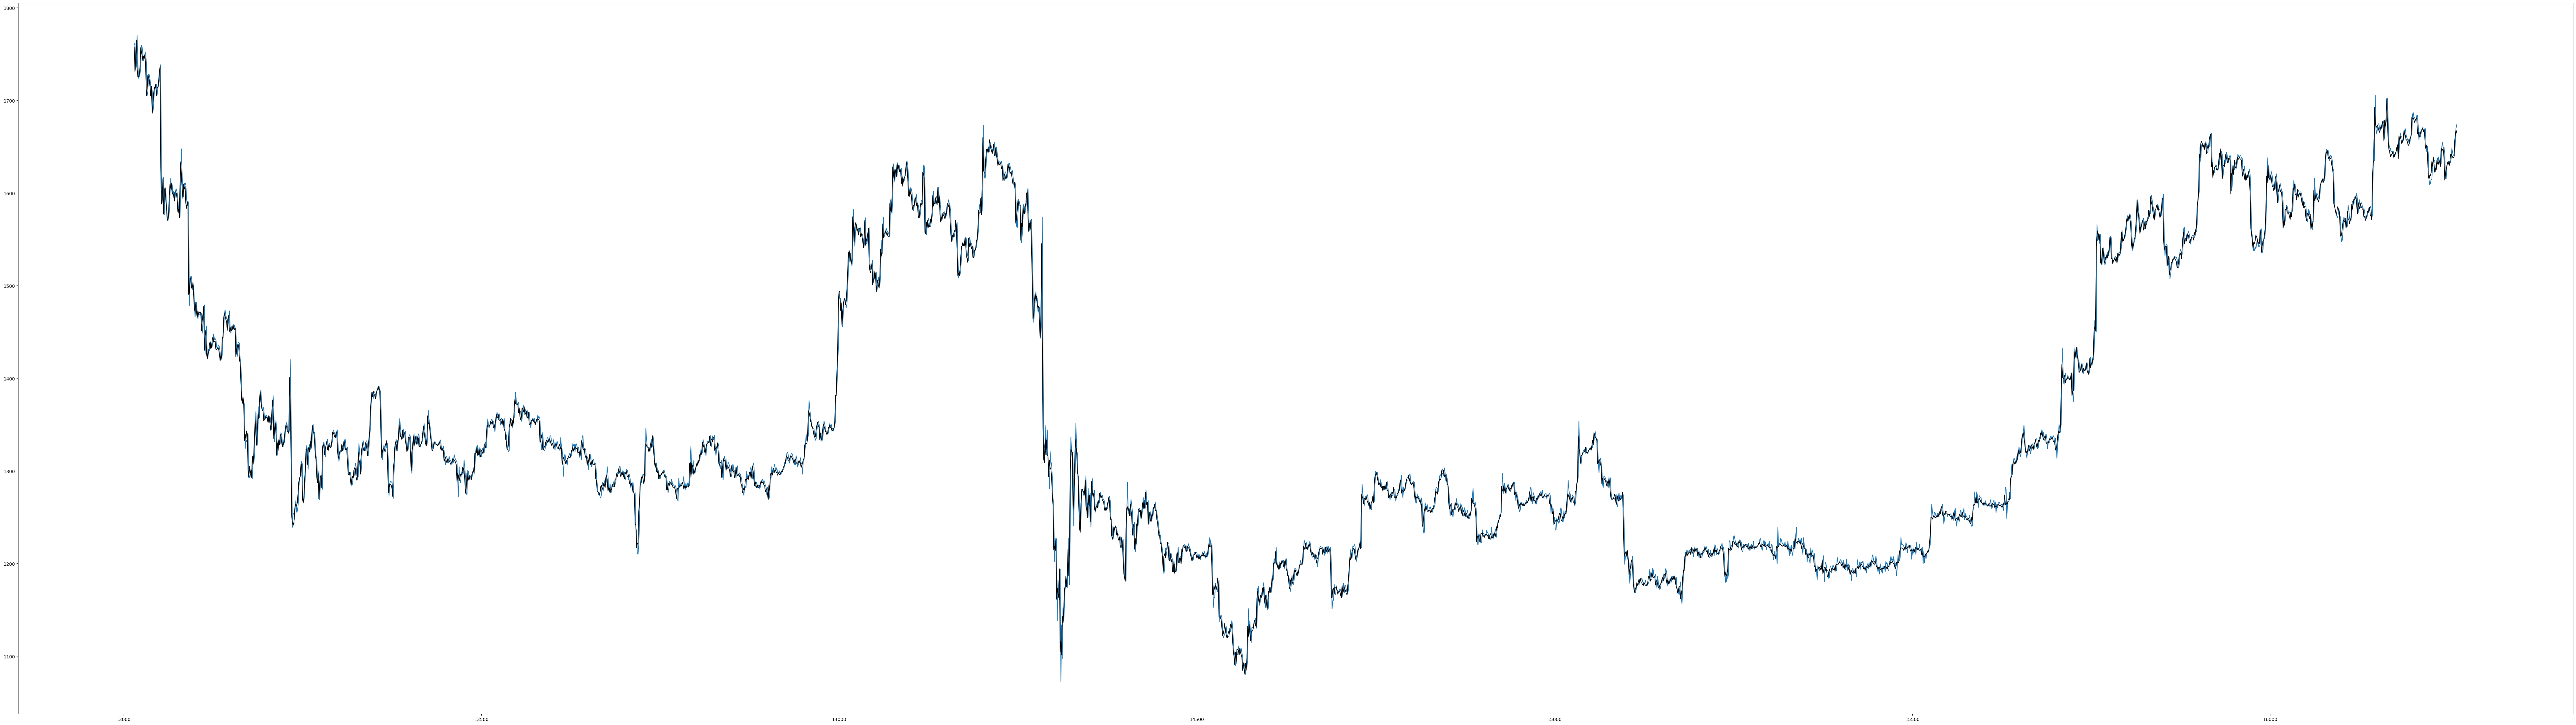

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(100, 28))

plt.plot(y_test['pred'])
plt.plot(y_test['close'], color='black')
plt.show()

## with backup data:

In [19]:
data_backup

,timestamp,date,open,high,low,close
16262,1675814400,2023-02-08 00:00:00,1670.50,1691.52,1667.43,1687.21
16263,1675818000,2023-02-08 01:00:00,1687.21,1699.00,1680.65,1681.97
16264,1675821600,2023-02-08 02:00:00,1681.96,1684.03,1676.01,1676.01
16265,1675825200,2023-02-08 03:00:00,1676.01,1683.17,1675.38,1680.33
16266,1675828800,2023-02-08 04:00:00,1680.34,1682.60,1678.00,1678.72
...,...,...,...,...,...,...
24354,1707336000,2024-02-07 20:00:00,2418.66,2445.00,2418.66,2438.64
24355,1707339600,2024-02-07 21:00:00,2438.64,2439.27,2424.86,2429.71
24356,1707343200,2024-02-07 22:00:00,2429.71,2431.16,2421.03,2424.75
24357,1707346800,2024-02-07 23:00:00,2424.76,2429.61,2421.81,2424.22


In [20]:
from talib import RSI
data_backup['rsi_14'] = RSI(data_backup['close'], timeperiod=14)

from talib import MA, SMA, EMA
data_backup['ma_9'] = MA(data_backup['close'], timeperiod=9)

data_backup.dropna(axis=0, inplace=True)

data_backup['close+1'] = data_backup['close'].shift(1)
data_backup['close+2'] = data_backup['close'].shift(2)
data_backup['close+3'] = data_backup['close'].shift(3)

data_backup['rsi_14+1'] = data_backup['rsi_14'].shift(1)
data_backup['rsi_14+2'] = data_backup['rsi_14'].shift(2)
data_backup['rsi_14+3'] = data_backup['rsi_14'].shift(3)

data_backup['ma_9+1'] = data_backup['ma_9'].shift(1)
data_backup['ma_9+2'] = data_backup['ma_9'].shift(2)
data_backup['ma_9+3'] = data_backup['ma_9'].shift(3)

data_backup['close_roc'] = ( data_backup['close'] - data_backup['close'].shift(1) ) / data_backup['close'].shift(1)
data_backup['close_roc'] = data_backup['close_roc'].shift(1)
data_backup['rsi_14_roc'] = ( data_backup['rsi_14'] - data_backup['rsi_14'].shift(1) ) / data_backup['rsi_14'].shift(1)
data_backup['rsi_14_roc'] = data_backup['rsi_14_roc'].shift(1)
data_backup['ma_9_roc'] = ( data_backup['ma_9'] - data_backup['ma_9'].shift(1) ) / data_backup['ma_9'].shift(1)
data_backup['ma_9_roc'] = data_backup['ma_9_roc'].shift(1)

data_backup['close_roll'] = data_backup['close'].rolling(window=14).mean()
data_backup['close_roll'] = data_backup['close_roll'].shift(1)
data_backup['rsi_14_roll'] = data_backup['rsi_14'].rolling(window=14).mean()
data_backup['rsi_14_roll'] = data_backup['rsi_14_roll'].shift(1)
data_backup['ma_9_roll'] = data_backup['ma_9'].rolling(window=14).mean()
data_backup['ma_9_roll'] = data_backup['ma_9_roll'].shift(1)

data_backup.dropna(axis=0, inplace=True)

In [21]:
data_backup.shape

(8069, 23)

In [22]:
inputs_backup = data_backup.iloc[:, [8,9,10,11,12,13,14,15,16,17,18,19,20,21,22]]

In [23]:
inputs_backup

,close+1,close+2,close+3,rsi_14+1,rsi_14+2,rsi_14+3,ma_9+1,ma_9+2,ma_9+3,close_roc,rsi_14_roc,ma_9_roc,close_roll,rsi_14_roll,ma_9_roll
16290,1634.12,1624.13,1618.97,34.727127,25.960791,20.863220,1640.955556,1641.837778,1644.457778,0.006151,0.337676,-0.000537,1645.018571,27.497757,1656.188810
16291,1629.98,1634.12,1624.13,32.984190,34.727127,25.960791,1638.428889,1640.955556,1641.837778,-0.002533,-0.050189,-0.001540,1642.047143,27.561183,1653.685556
16292,1632.47,1629.98,1634.12,35.094179,32.984190,34.727127,1636.411111,1638.428889,1640.955556,0.001528,0.063970,-0.001232,1640.531429,28.477358,1651.197698
16293,1634.81,1632.47,1629.98,37.098490,35.094179,32.984190,1634.694444,1636.411111,1638.428889,0.001433,0.057112,-0.001049,1639.687857,29.720086,1648.831508
16294,1632.90,1634.81,1632.47,36.118079,37.098490,35.094179,1632.321111,1634.694444,1636.411111,-0.001168,-0.026427,-0.001452,1638.630000,30.785048,1646.499762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24354,2418.66,2416.97,2409.59,74.945286,74.515328,72.609321,2386.678889,2379.568889,2374.405556,0.000699,0.005770,0.002988,2378.062857,61.474889,2369.015159
24355,2438.64,2418.66,2416.97,79.375495,74.945286,74.515328,2395.336667,2386.678889,2379.568889,0.008261,0.059113,0.003628,2383.462857,63.002504,2370.801587
24356,2429.71,2438.64,2418.66,73.149791,79.375495,74.945286,2401.751111,2395.336667,2386.678889,-0.003662,-0.078434,0.002678,2388.294286,64.144064,2373.194365
24357,2424.75,2429.71,2438.64,69.871719,73.149791,79.375495,2407.653333,2401.751111,2395.336667,-0.002041,-0.044813,0.002457,2392.741429,65.031411,2376.082143


In [24]:
inputs_backup_scaled = scaler.transform(inputs_backup)
pred_backup = model.predict(inputs_backup_scaled)

253/253 [==============================] - 1s 2ms/step


In [25]:
raw_data_backup = data_backup.iloc[:, [0,1,2,3,4,5,6,7]]
raw_data_backup['pred'] = pred_backup
#raw_data_backup['pred'] = raw_data_backup['pred'].shift(1)

/tmp/ipykernel_1551376/2509788400.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_data_backup['pred'] = pred_backup


In [26]:
raw_data_backup.to_excel('raw_data_feat_engineering.xlsx')

In [27]:
mean_squared_error(raw_data_backup['close'], pred_backup)

119.09640296796533

In [28]:
raw_data_backup

,timestamp,date,open,high,low,close,rsi_14,ma_9,pred
16290,1675926000,2023-02-09 07:00:00,1634.11,1635.55,1629.47,1629.98,32.984190,1638.428889,1638.328491
16291,1675929600,2023-02-09 08:00:00,1629.99,1637.60,1629.98,1632.47,35.094179,1636.411111,1632.852173
16292,1675933200,2023-02-09 09:00:00,1632.46,1636.36,1630.11,1634.81,37.098490,1634.694444,1628.664185
16293,1675940400,2023-02-09 11:00:00,1633.09,1639.99,1630.07,1632.90,36.118079,1632.321111,1632.970093
16294,1675944000,2023-02-09 12:00:00,1632.89,1643.55,1625.44,1636.20,39.112057,1630.638889,1631.693481
...,...,...,...,...,...,...,...,...,...
24354,1707336000,2024-02-07 20:00:00,2418.66,2445.00,2418.66,2438.64,79.375495,2395.336667,2426.848633
24355,1707339600,2024-02-07 21:00:00,2438.64,2439.27,2424.86,2429.71,73.149791,2401.751111,2447.473633
24356,1707343200,2024-02-07 22:00:00,2429.71,2431.16,2421.03,2424.75,69.871719,2407.653333,2433.117676
24357,1707346800,2024-02-07 23:00:00,2424.76,2429.61,2421.81,2424.22,69.513250,2414.251111,2423.129883
